# Narrative Analytics and Experimentation
### Introduction
This dataset contains daily streaming information on popular songs from many countries. My goal is to visualize this data and explore derived features. At the end, I will outline a research proposal for an experiment.
The data was taken form [this Kaggle Dataset](https://www.kaggle.com/edumucelli/spotifys-worldwide-daily-song-ranking). The user obtained the data from Spotify using the Spotify API.
### Outline 
1. Preliminary Analysis
<br>A. Prepare the Environment
<br>B. Primary Feature Attributes
<br>C. Missing Data
2. Feature Engineering
<br>A. Days Elapsed
<br>B. Regions
3. Distributions and Statistics
<br>A. Streams Distribution
<br>B. Top 10: Artists and Tracks
4. Analytics
<br>A. Position vs Streams
<br>B. Streams by Region
5. Research Proposal
<br>A. Hypothesis
<br>B. Experiment

# 1. Prelminary Analysis
### A. Prepare the Environment
Add imports to be used during analysis. Convert csv file to a pandas Dataframe.

In [1]:
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import matplotlib.pyplot as plt
import scipy.stats as sp
import scipy.optimize as spo
import warnings
warnings.filterwarnings("ignore")
%matplotlib inline

data_path = 'data/data.csv'
df = pd.read_csv(data_path)
df.drop('URL', axis = 1, inplace = True)

### B. Primary Feature Attributes
Display the primary features' attributes, such as type and preliminary statistics.

In [2]:
num_rows = len(df.index)
print ("Number of rows\t{}".format(num_rows))
df.head()

Number of rows	3441197


,Position,Track Name,Artist,Streams,Date,Region
0,1,Reggaetón Lento (Bailemos),CNCO,19272,2017-01-01,ec
1,2,Chantaje,Shakira,19270,2017-01-01,ec
2,3,Otra Vez (feat. J Balvin),Zion & Lennox,15761,2017-01-01,ec
3,4,Vente Pa' Ca,Ricky Martin,14954,2017-01-01,ec
4,5,Safari,J Balvin,14269,2017-01-01,ec


The song 'Reggaeton Lento (Bailemos)' by the artist CNCO was at the top position on January 1st, 2017 in Ecuador with 19272 streams. 
<br>Track Name and Artist are variable length strings which can contain any unicode characters. The first song includes an accent over the 'o' and parantheses.
<br>Region is a 2 character string indicating the country. The code may be found at the [Spotify language selection site](https://www.spotify.com/us/select-your-country/). The 2 characters appear at the end of the URL when selecting the country.

In [3]:
print ("Range of Position: {} - {}".format(df.Position.min(), df.Position.max()))
print ("Range of Streams: {} - {}".format(df.Streams.min(), df.Streams.max()))

Range of Position: 1 - 200
Range of Streams: 1001 - 11381520


<br>Position and streams are integers. Position has a range of 1 to 200; these are expected to be present in every sample ranking. Streams, on the other hand, vary day to day, but the total range is 1,001 to 11,381,520. That's an incredibly large number of streams for a single day! Let's see that row.

In [4]:
print (df.loc[df.Streams.idxmax()])

Position                                       1
Track Name    Despacito (Featuring Daddy Yankee)
Artist                                Luis Fonsi
Streams                                 11381520
Date                                  2017-05-27
Region                                    global
Name: 3145443, dtype: object


Of course, it's the global ranking for Despacito...
### C. Missing Data
Check NaNs in each column.

In [5]:
df_nans = df.isnull()
print (df_nans.sum())
# find percent similar NaN rows between Artist and Track Name
track_name_nans = df_nans['Track Name'][df_nans['Track Name'] == True].index
artist_nans = df_nans['Artist'][df_nans['Artist'] == True].index
nans_overlap = (track_name_nans == artist_nans).sum() / df_nans['Track Name'].sum() * 100.0
print ("\nPercent Overlap: {}%".format(nans_overlap))

Position        0
Track Name    657
Artist        657
Streams         0
Date            0
Region          0
dtype: int64

Percent Overlap: 100.0%


Remove the overlapping Track Name and Artist NaNs.

In [6]:
df_eng = df.copy()
df_eng.drop(track_name_nans, inplace = True)

# 2. Feature Engineering
Continue using the manipulated DatFrame for further manipulation.
### A. Days Elapsed
Although dates are a useful feature to humans, the format is tricky when performing numerical analysis. Here I will convert the Date feature to a Days feature. The count is 0 indexed where 0 Days is the first date in the dataset.

In [7]:
print ("First Date: {}\nLast Date: {}".format(df_eng.Date.min(),df_eng.Date.max())) # check first and last dates
Dates = pd.to_datetime(df_eng.Date) # redundant date format check
Days = Dates.sub(Dates[0], axis = 0) # subtract dates in pandas
Days = Days / np.timedelta64(1, 'D') # convert to float
print ("First Day Elapsed: {}\nLast Day Elapsed: {}".format(Days.min(), Days.max())) # check converted first and last days elapsed
df_eng['Days'] = Days # add column to our dataframe
df_eng.drop('Date', axis = 1, inplace = True)

First Date: 2017-01-01
Last Date: 2018-01-09
First Day Elapsed: 0.0
Last Day Elapsed: 373.0


### B. Regions
Provide a human readable format for Regions.

In [8]:
region_dict = {'ar':'Argentina', 'at':'Austria', 'au':'Australia', 'be':'Belgium', 'bo':'Bolivia', 'br':'Brazil', 'ca':'Canada', 'ch':'Switzerland', 'cl':'Chile', 'co':'Columbia', 'cr':'CostaRica', 'cz':'CzechRepublic', 'de':'Germany', 'dk':'Denmark', 'do':'DominicanRepublic',
 'ec':'Ecuador', 'ee':'Estonia', 'es':'Spain', 'fi':'Finland', 'fr':'France', 'gb':'UnitedKingdom', 'global':'World', 'gr':'Greece', 'gt':'Guatemala', 'hk':'HongKong', 'hn':'Honduras', 'hu':'Hungary', 'id':'Indonesia', 'ie':'Ireland',
 'is':'Iceland', 'it':'Italy', 'jp':'Japan', 'lt':'Lithuania', 'lu':'Luxemborg', 'lv':'Latvia', 'mx':'Mexico', 'my':'Malaysia', 'nl':'Netherlands', 'no':'Norway', 'nz':'NewZealand', 'pa':'Panama', 'pe':'Peru', 'ph':'Philippines', 'pl':'Poland',
 'pt':'Portugal', 'py':'Paraguay', 'se':'Sweden', 'sg':'Singapore', 'sk':'Slovakia', 'sv':'ElSalvador', 'tr':'Turkey', 'tw':'Taiwan', 'us':'USA', 'uy':'Uruguay',}

# 3. Distributions and Statistics
### A. Streams Distribution
Let's see how the Streams are distributed worldwide and in the US.

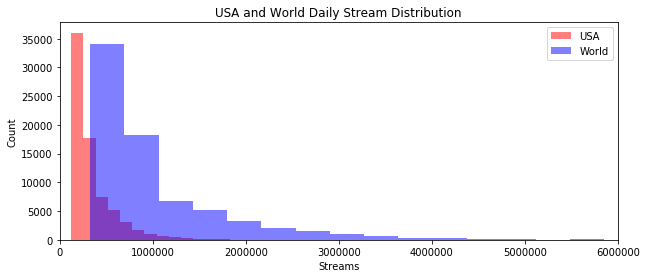

In [9]:
df_streams_us = df_eng[df_eng['Region'] == 'us']
df_streams_global = df_eng[df_eng['Region'] == 'global']

plt.figure(figsize = (10,4))
plt.hist(df_streams_us['Streams'], bins = 30, color = 'r', alpha = .5, label = 'USA')
plt.hist(df_streams_global['Streams'], bins = 30, color = 'b', alpha = .5, label = 'World')
plt.title('USA and World Daily Stream Distribution')
plt.xlabel('Streams')
plt.ylabel('Count')
plt.xlim(0, 6000000)
plt.legend();
plt.show()


### B. Top 10: Artists and Tracks
Find the top 10 most popular tracks and artists by stream count worldwide.

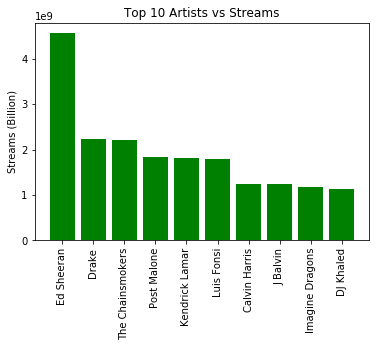

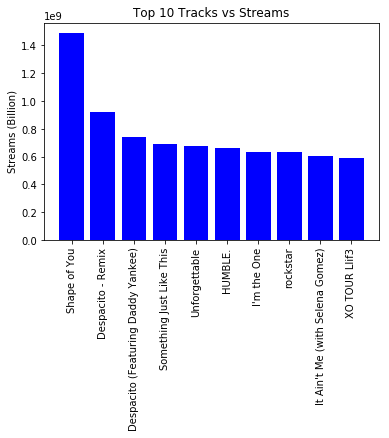

In [33]:
# get the top 10 tracks and artists
top_global_artist = df_streams_global.groupby(['Artist']).sum()
top_global_artist.sort_values(['Streams'], inplace = True, ascending = False)
top_global_track = df_streams_global.groupby(['Track Name']).sum()
top_global_track.sort_values(['Streams'], inplace = True, ascending = False)

# plot artists
global_artist_names = top_global_artist.index.values[:10]
global_artist_index = range(len((global_artist_names)))
plt.bar(global_artist_index, top_global_artist['Streams'][:10], color = 'g')
plt.xticks(global_artist_index, global_artist_names, rotation = 'vertical')
plt.ylabel('Streams (Billion)')
plt.title('Top 10 Artists vs Streams')
plt.show()

# plot tracks
global_track_names =  top_global_track.index.values[:10]
global_track_index = range(len((global_track_names)))
plt.bar(global_track_index, top_global_track['Streams'][:10], color = 'b')
plt.xticks(global_track_index, global_track_names, rotation = 'vertical')
plt.ylabel('Streams (Billion)')
plt.title('Top 10 Tracks vs Streams')
plt.show()

# 4. Analytics
Let's look beyond individual features and attempt to identify relationships or patterns in the data.
### A. Position vs Streams
It may seem obvious, a song that is streamed more is placed in a higher position. But let's see exactly how position relates to streams.

			Correlation
Position/Streams:	-0.789
Linear Regression:	0.789
Exponential Fit:	0.976


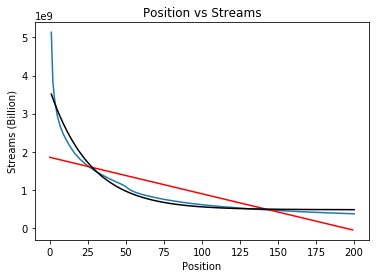

In [11]:
# correlation/Linear regression: Streams and Position
df_streams_position = df_eng.groupby(['Position']).sum()
df_streams_position.reset_index(inplace = True)
float_streams = df_streams_position['Streams'].astype(np.float)
# linear regression
slope_lin, intercept_lin, _,_,_ = sp.linregress(df_streams_position['Position'],float_streams)
regress_length = int(df_streams_position['Position'].max())
regress_lin = range(regress_length) * (np.ones(regress_length) * float(slope_lin)) + np.ones(regress_length) * float(intercept_lin)
# exponential regression
def exp_func(x, a, b, c):
    return a * np.exp(-b * x) + c
exp_fit, _ = spo.curve_fit(exp_func,  df_streams_position['Position'],  float_streams, p0=[-29000000000.0,1.064250352,4617322502.0])
exp_y = exp_func(df_streams_position['Position'], *exp_fit)
# correlation
corr_streams_position = float_streams.corr(df_streams_position['Position'])
print ("\t\t\tCorrelation\nPosition/Streams:\t{}".format(round(corr_streams_position,3)))
corr_lin = float_streams.corr(pd.Series(regress_lin))
print ("Linear Regression:\t{}".format(round(corr_lin,3)))
corr_exp = float_streams.corr(exp_y)
print ("Exponential Fit:\t{}".format(round(corr_exp,3)))
# plot Position vs Streams
fig_streams_position, ax_streams_position = plt.subplots()
ax_streams_position.plot(df_streams_position['Position'],float_streams);
ax_streams_position.plot(regress_lin,'r')
ax_streams_position.plot(df_streams_position['Position'], exp_y,'k')
ax_streams_position.set_xlabel('Position')
ax_streams_position.set_ylabel('Streams (Billion)')
ax_streams_position.set_title('Position vs Streams');

### B. Streams by Region
Each region has different access to Spotify and various competitors. First, let's look at the total streams by region then plot a time series of the top 10 most streamed regions.

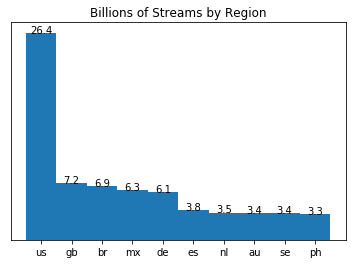

In [12]:
# Streams by region
df_streams = df_eng.groupby(['Region']).sum()
df_streams_sorted = df_streams.sort_values(by = ['Streams'], ascending=False)
top_10 = df_streams_sorted[1:11]
fig_streams, ax_streams = plt.subplots()
ax_streams.bar(range(len(top_10.index)), top_10.Streams, width = 1);
ax_streams.set_xticks(range(len(top_10.index)))
ax_streams.set_xticklabels(top_10.index);
ax_streams.set_yticks([]);
ax_streams.set_title('Billions of Streams by Region')
# display number above each bar
top_10_array = np.array(top_10['Streams'])
for x,y in zip(range(len(top_10_array)),top_10_array):
    ax_streams.text(x,y,round(y / 1000000000,1),horizontalalignment='center');

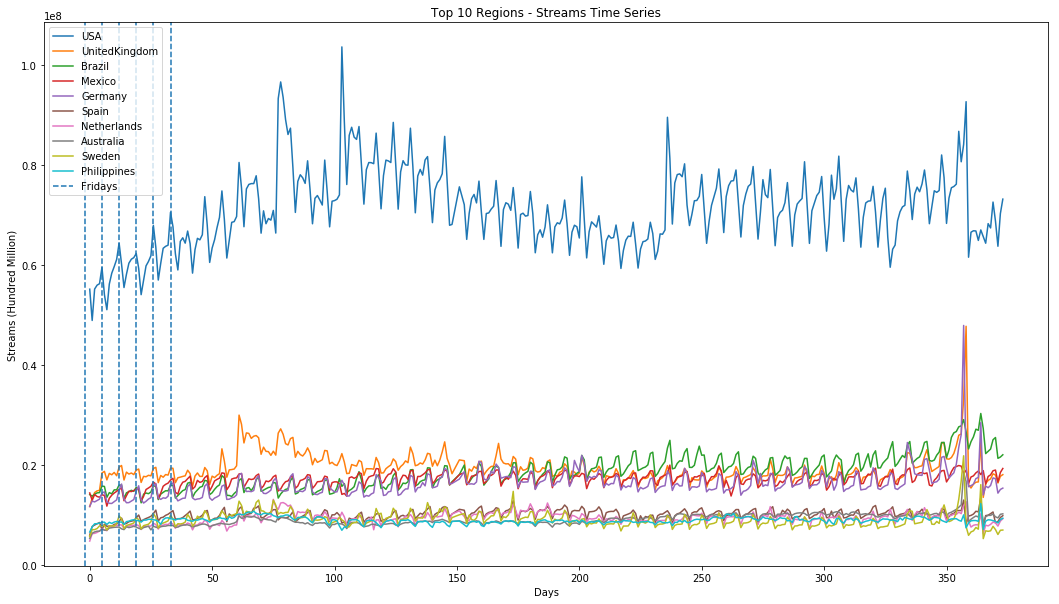

In [13]:
# top 10 regions - stream time series
df_stream_time = df_eng.groupby(['Region','Days']).sum()
df_stream_time.reset_index(inplace = True)
top_10_time = df_stream_time[df_stream_time['Region'].isin(top_10.index)]
plt.figure(figsize = (18,10))
for region in top_10.index:
    temp_df = top_10_time[top_10_time['Region'] == region]
    plt.plot(temp_df['Days'], temp_df['Streams'], label = region_dict[region]);
# Weekly peaks? Fridays are -2,5,12,19
fridays = list(range(0,int(top_10_time['Days'].max()),7))
fridays -= np.ones(len(fridays)) * 2
for friday in fridays[:6]:
    sat_plot = plt.axvline(friday, linestyle = '--')
sat_plot.set_label('Fridays')
# label seasons
plt.xlabel('Days')
plt.ylabel('Streams (Hundred Million)')
plt.title('Top 10 Regions - Streams Time Series')
plt.legend();

In [34]:
# 4 US surges (78, 103, 236, 358)
df_us_stream_time = df_stream_time[df_stream_time['Region'] == 'us'].reset_index()
# streams surge locator function
def surge_locator(df, lower, upper):
    surge_idx = df['Streams'][lower:upper].idxmax() # look between lower and upper
    surge_stream_time = df.loc[surge_idx]
    surge = surge_stream_time['Days']
    df_surge = df_eng[df_eng['Region'] == 'us']
    df_surge = df_surge[df_surge['Days'] == surge]
    df_surge.drop(columns = ['Streams', 'Region'], inplace = True)
    return (df_surge.sort_values(by = ['Position'])[:5])

# first surge = 78, 96540599
first_surge = surge_locator(df_us_stream_time, 60, 90)
print ("First Surge: Top 5 Tracks")
print (first_surge)
# second surge = 103, 103538141
second_surge = surge_locator(df_us_stream_time, 90, 120)
print ("\nSecond Surge: Top 5 Tracks")
print (second_surge)
# third surge = 236, 89480323
third_surge = surge_locator(df_us_stream_time, 210, 250)
print ("\nThird Surge: Top 5 Tracks")
print (third_surge)
# fourth surge = 358, 92597380
fourth_surge = surge_locator(df_us_stream_time, 330, 370)
print ("\nFourth Surge: Top 5 Tracks")
print (fourth_surge)

First Surge: Top 5 Tracks
        Position    Track Name Artist  Days
787222         1  Passionfruit  Drake  78.0
787223         2      Portland  Drake  78.0
787224         3    Free Smoke  Drake  78.0
787225         4   Gyalchester  Drake  78.0
787226         5          Blem  Drake  78.0

Second Surge: Top 5 Tracks
        Position               Track Name          Artist   Days
792222         1                  HUMBLE.  Kendrick Lamar  103.0
792223         2                     DNA.  Kendrick Lamar  103.0
792224         3                 ELEMENT.  Kendrick Lamar  103.0
792225         4  LOYALTY. FEAT. RIHANNA.  Kendrick Lamar  103.0
792226         5                     YAH.  Kendrick Lamar  103.0

Third Surge: Top 5 Tracks
        Position                           Track Name          Artist   Days
818222         1             Look What You Made Me Do    Taylor Swift  236.0
818223         2                        XO TOUR Llif3    Lil Uzi Vert  236.0
818224         3                  

# 5. Research Proposal
Popular artists, such as Drake or Kendrick Lamar, are known to release singles before the release of an album. This has been a common practice for some time in popular music. It has recently become popular to release only a few tracks at a time, releasing smaller EPs more frequently than one large LP. Does this have an impact on number of streams? 
### A. Hypothesis
Artists who release large amounts of music less frequently may be able to increase their popularity.
### B. Experiment
There are two groups of Artists in this experiment: those who release small amounts of music frequently (EP Artists) and those who release large amounts of music less frequently (LP Artists). To be more specific, EP Artists will be defined by releasing no more than 4 songs every 3 months. LP Artists will be defined by releasing more than 8 songs in 1 month, but not again for 6 months. Artists who release less than 8 songs every year will not be considered.
<br>It would be ideal to use the same Artist throughout this experiment, but convincing an Artist to release their music in a certain way may be harder than looking at Artists who have already done so. Looking at different artists, however introduces a small amount of variation to the data. As long as we increase the sample size, the variation should converge on some central tendency. However, in our results, it will be necessary to use a t-test to verify that the groups we have identified are, in fact, unique and have significant differences in the measured outcomes.
<br>This variation may be of interest and will allow us to separate the analysis into more specified groups. One such grouping may be genre. The omnipresent 'mixtape' in rap music is as common as the one-time-hit in electronic music. The difference between genre may impact the number of streams and the ranking of each song (certain genres fall in and out of fashion with pop, hip hop and electronic music currently dominating the market).
<br>The metric to evaluate Artist popularity will be average number of streams per song and average position of highest ranking song. I suggest that an LP Artist will have 2,500 more streams per song and rank higher by 5 positions than EP Artists. The t-test results will validate this if the p-value is greater than 0.05. If the hypothesis is true, then record labels can tell their artists to release smaller amounts of music more frequently.
<br>The data above provides a groundwork for such an experiment. The Position vs Stream graph shows that the number of streams increases exponentially with the position. If an Artist can breach the upper echelon, then they will receive many more streams. As can be seen in the Streams vs Region Time Series, surges in stream count are due to both LP Artists (Drake and Kendrick Lamar). By looking through the data it may be discovered which kind of Artist is more popular.